In [1]:
stock_1 = symbols('V')
stock_2 = symbols('MA')
start_date = '2019-5-1'
end_date = '2020-5-1'
HEDGE_LOOKBACK = 21
MIN_WEIGHT = 0.2
DESIRED_PVALUE = 0.01

In [2]:
import numpy as np
import pandas as pd
import statsmodels.tsa.stattools as sm
import statsmodels.stats.diagnostic as sd
from scipy.stats import shapiro, pearsonr, jarque_bera
from pykalman import KalmanFilter
import math
from scipy.stats import linregress
import itertools
from matplotlib import pyplot as plt

def get_spreads(s1_price, s2_price):
    length = len(s1_price)-HEDGE_LOOKBACK
    spreads = []
    for i in range(length):
        start_index = len(s1_price)-length+i
        try:
            hedge = linregress(np.log(s2_price[start_index-HEDGE_LOOKBACK:start_index]),np.log(s1_price[start_index-HEDGE_LOOKBACK:start_index])).slope
            intercept = linregress(np.log(s2_price[start_index-HEDGE_LOOKBACK:start_index]),np.log(s1_price[start_index-HEDGE_LOOKBACK:start_index])).intercept
        except:
            return
        spreads = np.append(spreads, np.log(s1_price[i]) - hedge*np.log(s2_price[i])-intercept)
    return spreads

def run_kalman(price_history):
    kf_stock = KalmanFilter(transition_matrices = [1], observation_matrices = [1], initial_state_mean = price_history.values[0], 
                            initial_state_covariance = 1, observation_covariance=1, transition_covariance=.05)
    return kf_stock.smooth(price_history.values)[0].flatten()

# s1_price = run_kalman(get_pricing(stock_1,start_date=start_date, end_date=end_date, start_offset=HEDGE_LOOKBACK).close_price)
# s2_price = run_kalman(get_pricing(stock_2,start_date=start_date, end_date=end_date, start_offset=HEDGE_LOOKBACK).close_price)

s1_price = get_pricing(stock_1,start_date=start_date, end_date=end_date, start_offset=HEDGE_LOOKBACK).close_price
s2_price = get_pricing(stock_2,start_date=start_date, end_date=end_date, start_offset=HEDGE_LOOKBACK).close_price

spreads = get_spreads(s1_price,s2_price)

In [3]:
def correlation1(a,b):
    r, p = pearsonr(a,b)
    if p<DESIRED_PVALUE:
        return r
    else:
        return float('NaN')
    return r

def cointegration1(a, b):
    score, pvalue, _ = sm.coint(a, b)
    return pvalue

def adf_pvalue1(spreads, s1_price, s2_price):
    if (sm.adfuller(s1_price,1)[1]>DESIRED_PVALUE) and (sm.adfuller(s2_price,1)[1]>DESIRED_PVALUE):
        return sm.adfuller(spreads,1)[1]
    else:
        return float('NaN')

def hurst_hvalue1(series):
    max_window = len(series)-1
    min_window = 10
    window_sizes = list(map(lambda x: int(10**x),np.arange(math.log10(min_window), math.log10(max_window), 0.25)))
    window_sizes.append(len(series))
    RS = []
    for w in window_sizes:
        rs = []
        for start in range(0, len(series), w):
            if (start+w)>len(series):
                break
            incs = series[start:start+w][1:] - series[start:start+w][:-1]

#             # SIMPLIFIED
#             R = max(series[start:start+w]) - min(series[start:start+w])  # range in absolute values
#             S = np.std(incs, ddof=1) 

            #NOT SIMPLIFIED
            mean_inc = (series[start:start+w][-1] - series[start:start+w][0]) / len(incs)
            deviations = incs - mean_inc
            Z = np.cumsum(deviations)
            R = max(Z) - min(Z)
            S = np.std(incs, ddof=1)

            if R != 0 and S != 0:
                rs.append(R/S)
        RS.append(np.mean(rs))
    A = np.vstack([np.log10(window_sizes), np.ones(len(RS))]).T
    H, c = np.linalg.lstsq(A, np.log10(RS), rcond=-1)[0]
    return H

def half_life1(spreads): 
    spreads = spreads[-HEDGE_LOOKBACK::]
    lag = np.roll(spreads, 1)
    ret = spreads - lag
    return(-np.log(2) / linregress(lag, ret).slope)

def shapiro_pvalue1(spreads):
    w, p = shapiro(spreads)
    return p

def zscore1(spreads):
    return (spreads[-1]-spreads.mean())/spreads.std()

def alpha1(price1, price2):
    slope, intercept, rvalue, pvalue, stderr = linregress(price2, price1)
    y_target_shares = 1
    x_target_shares = -slope
    notionalDol =  abs(y_target_shares * price1[-1]) + abs(x_target_shares * price2[-1])
    (y_target_pct, x_target_pct) = (y_target_shares * price1[-1] / notionalDol, x_target_shares * price2[-1] / notionalDol)
    if (abs(x_target_pct) > MIN_WEIGHT) and (abs(y_target_pct) > MIN_WEIGHT) and (pvalue<DESIRED_PVALUE):
        return slope
    else:
        return float('NaN')

def ljung_box1(spreads):
    return max(sd.acorr_ljungbox(spreads)[1])

def jarque_bera1(spreads):
    from scipy.stats import jarque_bera
    w, p = jarque_bera(spreads)
    return p

correlation = correlation1(s1_price, s2_price)
cointegration = cointegration1(s1_price, s2_price)
adf_pvalue = adf_pvalue1(spreads, s1_price, s2_price)
hurst_hvalue = hurst_hvalue1(spreads)
half_life = half_life1(spreads)
shapiro_pvalue = shapiro_pvalue1(spreads)
zscore = zscore1(spreads)
alpha = alpha1(s1_price, s2_price)
ljung_box = ljung_box1(spreads)
jarque_bera = jarque_bera1(spreads)

print(stock_1, stock_2)
print('Correlation',correlation)
print('Cointegration',cointegration)
print('ADF', adf_pvalue)
print('Hurst', hurst_hvalue)
print('Half Life', half_life)
print('Shapiro Wilk',shapiro_pvalue)
print('Zscore',zscore)
print('Alpha',alpha)
print('Ljung Box', ljung_box)
print('Jarque Bera',jarque_bera)

Equity(35920 [V]) Equity(32146 [MA])
Correlation 0.991371510532
Cointegration 5.82431735708e-08
ADF 9.98823075908e-08
Hurst 0.417426516271
Half Life 0.740712335396
Shapiro Wilk 9.397071698913351e-05
Zscore 1.86726752355
Alpha 0.527287928503
Ljung Box 2.96182511439e-20
Jarque Bera 2.39992903328e-09


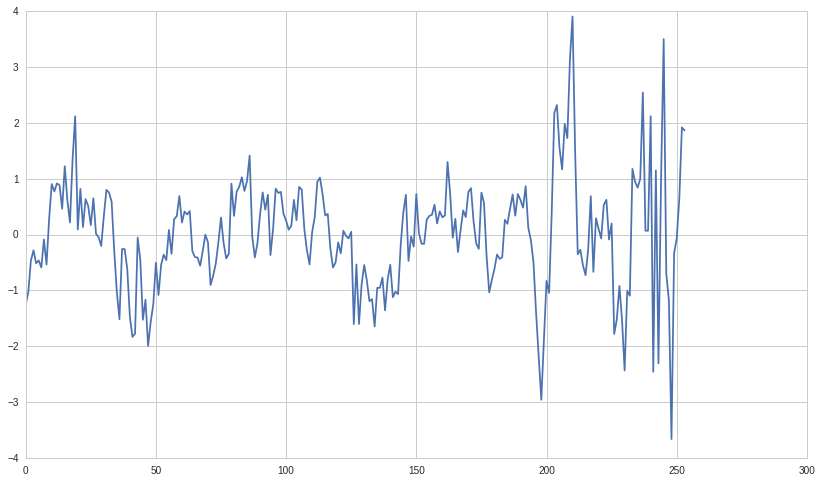

In [4]:
zscores1 = []
for i in range(len(spreads)):
    zscore = (spreads[i]-spreads.mean())/spreads.std()
    zscores1.append(zscore)
plt.plot(zscores1)

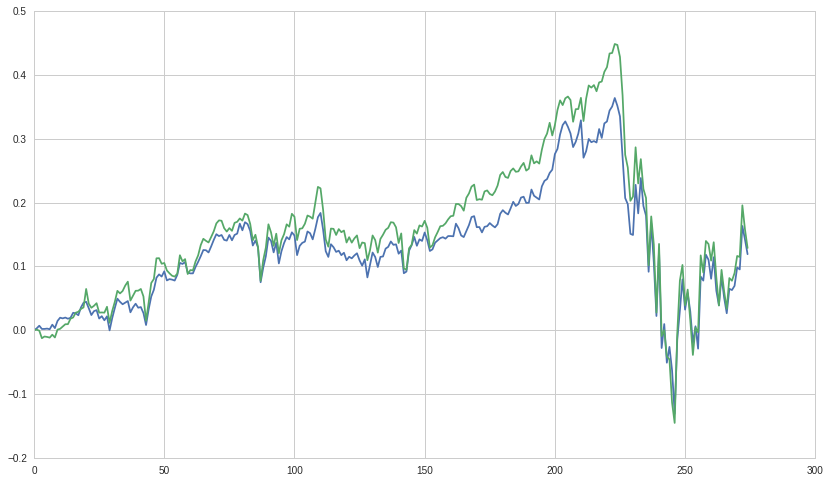

In [5]:
s1_initial = s1_price[0]
s2_initial = s2_price[0]
s1_final = [(val-s1_initial)/s1_initial for val in s1_price]
s2_final = [(val-s2_initial)/s2_initial for val in s2_price]
plt.plot(s1_final)
plt.plot(s2_final)

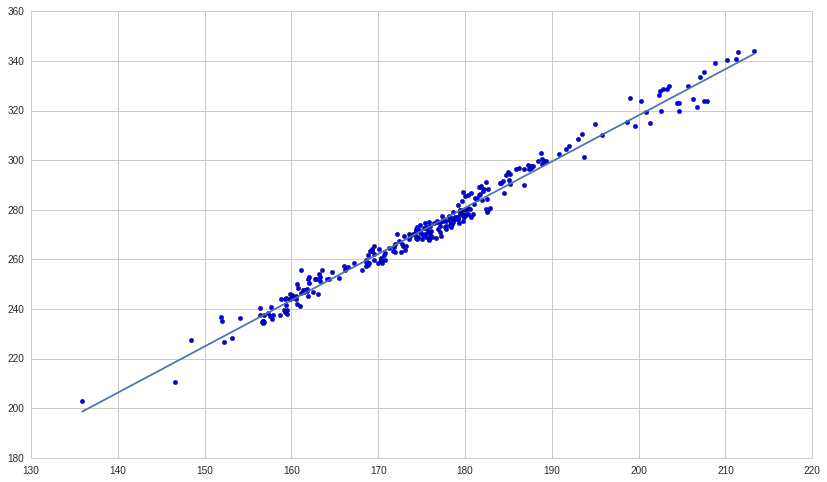

In [6]:
plt.scatter(s1_price,s2_price)
plt.plot(np.unique(s1_price), np.poly1d(np.polyfit(s1_price, s2_price, 1))(np.unique(s1_price)))